In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.manifold import MDS
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score,StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

uci_test = pd.read_csv('./Data/UCI HAR Data Frame/uci_test.csv')
uci_train = pd.read_csv('./Data/UCI HAR Data Frame/uci_train.csv')
uci_df = pd.concat([uci_train,uci_test],ignore_index = True)

uci_df

subject          activity  tBodyAcc-mean()-X  tBodyAcc-mean()-Y  \
0            1          STANDING           0.288585          -0.020294   
1            1          STANDING           0.278419          -0.016411   
2            1          STANDING           0.279653          -0.019467   
3            1          STANDING           0.279174          -0.026201   
4            1          STANDING           0.276629          -0.016570   
...        ...               ...                ...                ...   
10294       24  WALKING_UPSTAIRS           0.310155          -0.053391   
10295       24  WALKING_UPSTAIRS           0.363385          -0.039214   
10296       24  WALKING_UPSTAIRS           0.349966           0.030077   
10297       24  WALKING_UPSTAIRS           0.237594           0.018467   
10298       24  WALKING_UPSTAIRS           0.153627          -0.018437   

       tBodyAcc-mean()-Z  tBodyAcc-std()-X  tBodyAcc-std()-Y  \
0              -0.132905         -0.995279         -0.983111   
1              -0.123520         -0.998245         -0.975300   
2              -0.113462         -0.995380         -0.967187   
3              -0.123283         -0.996091         -0.983403   
4              -0.115362         -0.998139         -0.980817   
...                  ...               ...               ...   
10294          -0.099109         -0.287866         -0.140589   
10295          -0.105915         -0.305388          0.028148   
10296          -0.115788         -0.329638         -0.042143   
10297          -0.096499         -0.323114         -0.229775   
10298          -0.137018         -0.330046         -0.195253   

       tBodyAcc-std()-Z  tBodyAcc-mad()-X  tBodyAcc-mad()-Y  ...  \
0             -0.913526         -0.995112         -0.983185  ...   
1             -0.960322         -0.998807         -0.974914  ...   
2             -0.978944         -0.996520         -0.963668  ...   
3             -0.990675         -0.997099         -0.982750  ...   
4             -0.990482         -0.998321         -0.979672  ...   
...                 ...               ...               ...  ...   
10294         -0.215088         -0.356083         -0.148775  ...   
10295         -0.196373         -0.373540         -0.030036  ...   
10296         -0.250181         -0.388017         -0.133257  ...   
10297         -0.207574         -0.392380         -0.279610  ...   
10298         -0.164339         -0.430974         -0.218295  ...   

       fBodyBodyGyroJerkMag-meanFreq()  fBodyBodyGyroJerkMag-skewness()  \
0                            -0.074323                        -0.298676   
1                             0.158075                        -0.595051   
2                             0.414503                        -0.390748   
3                             0.404573                        -0.117290   
4                             0.087753                        -0.351471   
...                                ...                              ...   
10294                         0.074472                        -0.376278   
10295                         0.101859                        -0.320418   
10296                        -0.066249                        -0.118854   
10297                        -0.046467                        -0.205445   
10298                        -0.010386                        -0.072237   

       fBodyBodyGyroJerkMag-kurtosis()  angle(tBodyAccMean,gravity)  \
0                            -0.710304                    -0.112754   
1                            -0.861499                     0.053477   
2                            -0.760104                    -0.118559   
3                            -0.482845                    -0.036788   
4                            -0.699205                     0.123320   
...                                ...                          ...   
10294                        -0.750809                    -0.337422   
10295                        -0.700274                    -0.73

The current features displayed above assume a fixed orientation of the smartphone device. For example, if the device is held as shown in [this video](http://www.youtube.com/watch?v=XOEN9W05_4A) (when the subject is standing), then:

- The $x$-axis corresponds to the **up-down** direction,
- The $y$-axis corresponds to the **forward-backward** direction, and
- The $z$-axis corresponds to the **left-right** direction.

The naïve $\ell_2$-distance-based approach classifies different activities based on features extracted under this fixed orientation. As a result, the classification task becomes significantly easier due to this consistency in device placement.

However, in real-world scenarios, users are unlikely to keep their phones in a fixed orientation. This raises the question: **Will our naïve approach remain effective when the phone orientation varies?**

To explore this, we propose to test the model’s robustness by permuting the axes of the feature set. Specifically, we will permute the $x$, $y$, and $z$ axes of all features (e.g., mean, standard deviation, median absolute deviation, etc.) to simulate alternative phone orientations. For example, swapping the $x$ and $y$ axes would mimic the effect of holding the phone in a vertical rather than horizontal orientation.

This synthetic experiment will help us evaluate how sensitive the current model is to changes in device orientation, and whether additional processing or more robust features are needed for real-world deployment.


# Data from one subject
Here validate working with a random subject:

In [2]:
# chose a subject to fix
subject_index = 1 
row_mask = uci_df['subject'] == subject_index
subject_df = uci_df.loc[row_mask]

## Per-Sample Axis Permutation

For each sample, we will randomly relabel the $x$, $y$, and $z$ axis. This simulates a different phone orientation.

In [3]:
import re
df = subject_df.copy() 

# STEP 1: Automatically get all 3D prefixes
xyz_cols = [col for col in df.columns if re.search(r'-[XYZ]$', col)] 

feature_prefixes = set() # will consist of prefixes (without XYZ) e.g. tBodyAcc-mean() 
for col in xyz_cols:
    match = re.match(r'(.+)-[XYZ]$', col) # does col end with X, Y or Z. 
    if match: # if col ends with X, Y or Z match.group(1) gives the name before the -[XYZ] e.g. tBodyAcc-mean() for tBodyAcc-mean()-X
        feature_prefixes.add(match.group(1)) # add this to the set
feature_prefixes = sorted(feature_prefixes)

axes = ['X', 'Y', 'Z']


# STEP 2: Build a mapping from feature_prefix -> axis -> column name
feature_map = {}
for prefix in feature_prefixes:
    feature_map[prefix] = {ax: f"{prefix}-{ax}" for ax in axes if f"{prefix}-{ax}" in df.columns}
    # If any axis is missing, skip this feature
    if len(feature_map[prefix]) != 3:
        del feature_map[prefix]



# STEP 3: Apply a random permutation row-by-row
shuffled_df = df.copy()
for i in range(len(df)): # for each row, we will randomly permuate x,y and z.
    perm = np.random.permutation(axes)  # e.g. ['Y','X','Z'] or ['Z','Y','X'] etc.
    for prefix, axis_map in feature_map.items():
        # Original values in X,Y,Z order
        orig_values = [df.at[i, axis_map[ax]] for ax in axes]
        # Permuted values, assign to shuffled_df
        for idx, ax in enumerate(axes):
            shuffled_df.at[i, axis_map[ax]] = orig_values[perm.tolist().index(ax)]

shuffled_df.head()


subject  activity  tBodyAcc-mean()-X  tBodyAcc-mean()-Y  tBodyAcc-mean()-Z  \
0        1  STANDING          -0.132905          -0.020294           0.288585   
1        1  STANDING           0.278419          -0.016411          -0.123520   
2        1  STANDING           0.279653          -0.113462          -0.019467   
3        1  STANDING          -0.123283           0.279174          -0.026201   
4        1  STANDING          -0.115362          -0.016570           0.276629   

   tBodyAcc-std()-X  tBodyAcc-std()-Y  tBodyAcc-std()-Z  tBodyAcc-mad()-X  \
0         -0.913526         -0.983111         -0.995279         -0.923527   
1         -0.998245         -0.975300         -0.960322         -0.998807   
2         -0.995380         -0.978944         -0.967187         -0.996520   
3         -0.990675         -0.996091         -0.983403         -0.989302   
4         -0.990482         -0.980817         -0.998139         -0.990441   

   tBodyAcc-mad()-Y  ...  fBodyBodyGyroJerkMag-meanFreq()  \
0         -0.983185  ...                        -0.074323   
1         -0.974914  ...                         0.158075   
2         -0.977469  ...                         0.414503   
3         -0.997099  ...                         0.404573   
4         -0.979672  ...                         0.087753   

   fBodyBodyGyroJerkMag-skewness()  fBodyBodyGyroJerkMag-kurtosis()  \
0                        -0.298676                        -0.710304   
1                        -0.595051                        -0.861499   
2                        -0.390748                        -0.760104   
3                        -0.117290                        -0.482845   
4                        -0.351471                        -0.699205   

   angle(tBodyAccMean,gravity)  angle(tBodyAccJerkMean),gravityMean)  \
0                    -0.112754                              0.030400   
1                     0.053477                             -0.007435   
2                    -0.118559                              0.177899   
3                    -0.036788                             -0.012892   
4                     0.123320                              0.122542   

   angle(tBodyGyroMean,gravityMean)  angle(tBodyGyroJerkMean,gravityMean)  \
0                         -0.464761                             -0.018446   
1                         -0.732626                              0.703511   
2                          0.100699                              0.808529   
3                          0.640011                             -0.485366   
4                          0.693578                             -0.615971   

   angle(X,gravityMean)  angle(Y,gravityMean)  angle(Z,gravityMean)  
0             -0.841247              0.179941             -0.058627  
1             -0.844788              0.180289             -0.054317  
2             -0.848933              0.180637             -0.049118  
3             -0.848649              0.181935             -0.047663  
4             -0.847865              0.185151             -0.043892  

[5 rows x 563 columns]

Now, the $x$ direction for row $0$ and row $1$ may mean different: maybe for row $0$ it means up-down, and row $1$ it means forward-backward.

In [4]:
feature_prefixes

['fBodyAcc-energy()',
 'fBodyAcc-entropy()',
 'fBodyAcc-iqr()',
 'fBodyAcc-kurtosis()',
 'fBodyAcc-mad()',
 'fBodyAcc-max()',
 'fBodyAcc-maxInds',
 'fBodyAcc-mean()',
 'fBodyAcc-meanFreq()',
 'fBodyAcc-min()',
 'fBodyAcc-skewness()',
 'fBodyAcc-std()',
 'fBodyAccJerk-energy()',
 'fBodyAccJerk-entropy()',
 'fBodyAccJerk-iqr()',
 'fBodyAccJerk-kurtosis()',
 'fBodyAccJerk-mad()',
 'fBodyAccJerk-max()',
 'fBodyAccJerk-maxInds',
 'fBodyAccJerk-mean()',
 'fBodyAccJerk-meanFreq()',
 'fBodyAccJerk-min()',
 'fBodyAccJerk-skewness()',
 'fBodyAccJerk-std()',
 'fBodyGyro-energy()',
 'fBodyGyro-entropy()',
 'fBodyGyro-iqr()',
 'fBodyGyro-kurtosis()',
 'fBodyGyro-mad()',
 'fBodyGyro-max()',
 'fBodyGyro-maxInds',
 'fBodyGyro-mean()',
 'fBodyGyro-meanFreq()',
 'fBodyGyro-min()',
 'fBodyGyro-skewness()',
 'fBodyGyro-std()',
 'tBodyAcc-energy()',
 'tBodyAcc-entropy()',
 'tBodyAcc-iqr()',
 'tBodyAcc-mad()',
 'tBodyAcc-max()',
 'tBodyAcc-mean()',
 'tBodyAcc-min()',
 'tBodyAcc-std()',
 'tBodyAccJerk-energy

# $\ell_2$ Distance Approach with Random Axis Permutation

In [31]:
import time
from tqdm import tqdm

In [32]:
%%time
def l2_dist(x,y):
    diff_vector = x - y
    return np.linalg.norm(x-y)


one_subject_df_feature_vectors = shuffled_df.iloc[:,2:]
N = len(shuffled_df)

dm_shuffled = np.zeros((N,N))
np.fill_diagonal(dm_shuffled,0)

for i in tqdm(range(N)):
    for j in range(i,N):
        x = one_subject_df_feature_vectors.iloc[i]
        y = one_subject_df_feature_vectors.iloc[j]
        dist = l2_dist(x,y)
        dm_shuffled[i][j] = dist

dm_shuffled += dm_shuffled.T



        

100%|█████████████████████████████████████████| 347/347 [00:04<00:00, 84.19it/s]

CPU times: user 4.09 s, sys: 440 ms, total: 4.53 s
Wall time: 4.13 s


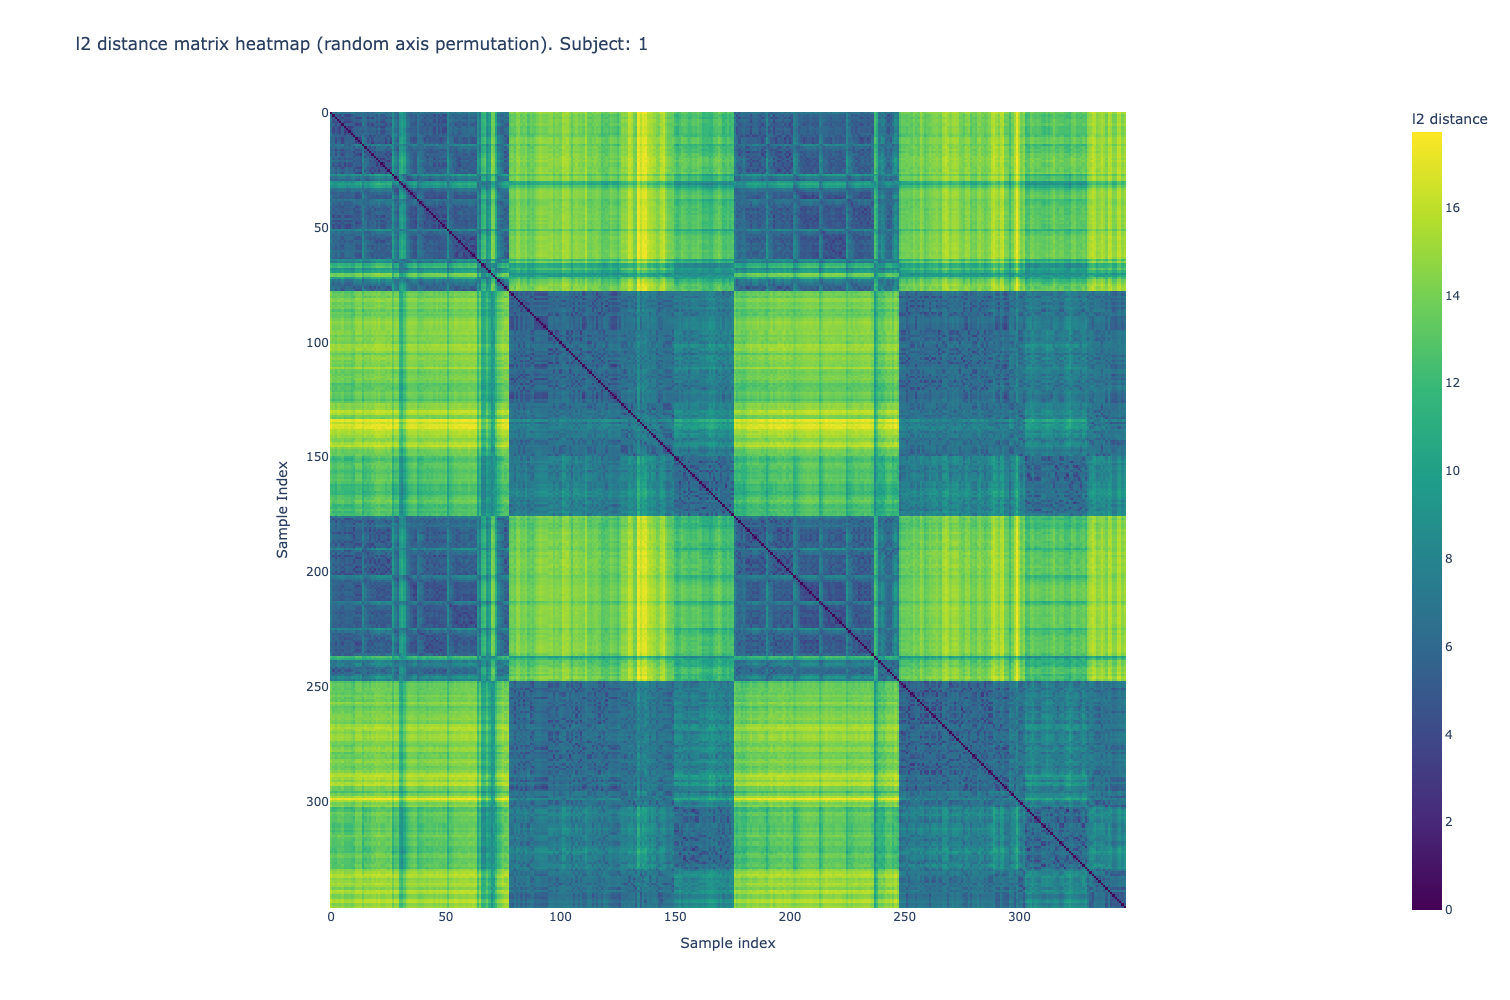

In [33]:
dm_shuffled_df = pd.DataFrame(dm_shuffled)

fig = px.imshow(dm_shuffled_df,
                labels = dict( x = 'Sample index',y = 'Sample Index', color = 'l2 distance'),
                color_continuous_scale = 'Viridis',
                title = f'l2 distance matrix heatmap (random axis permutation). Subject: {subject_index}'
               )

fig.update_layout(width = 1000,height = 1000)

fig.show()

# MDS Visualization of the $\ell_2$ distance matrix

We visualize the $\ell_2$ distance matrix with MDS in $\mathbb{R}^{3}$. It appears that there is a nice separation of activities, understood even from basic $\ell_2$ distance comparison.

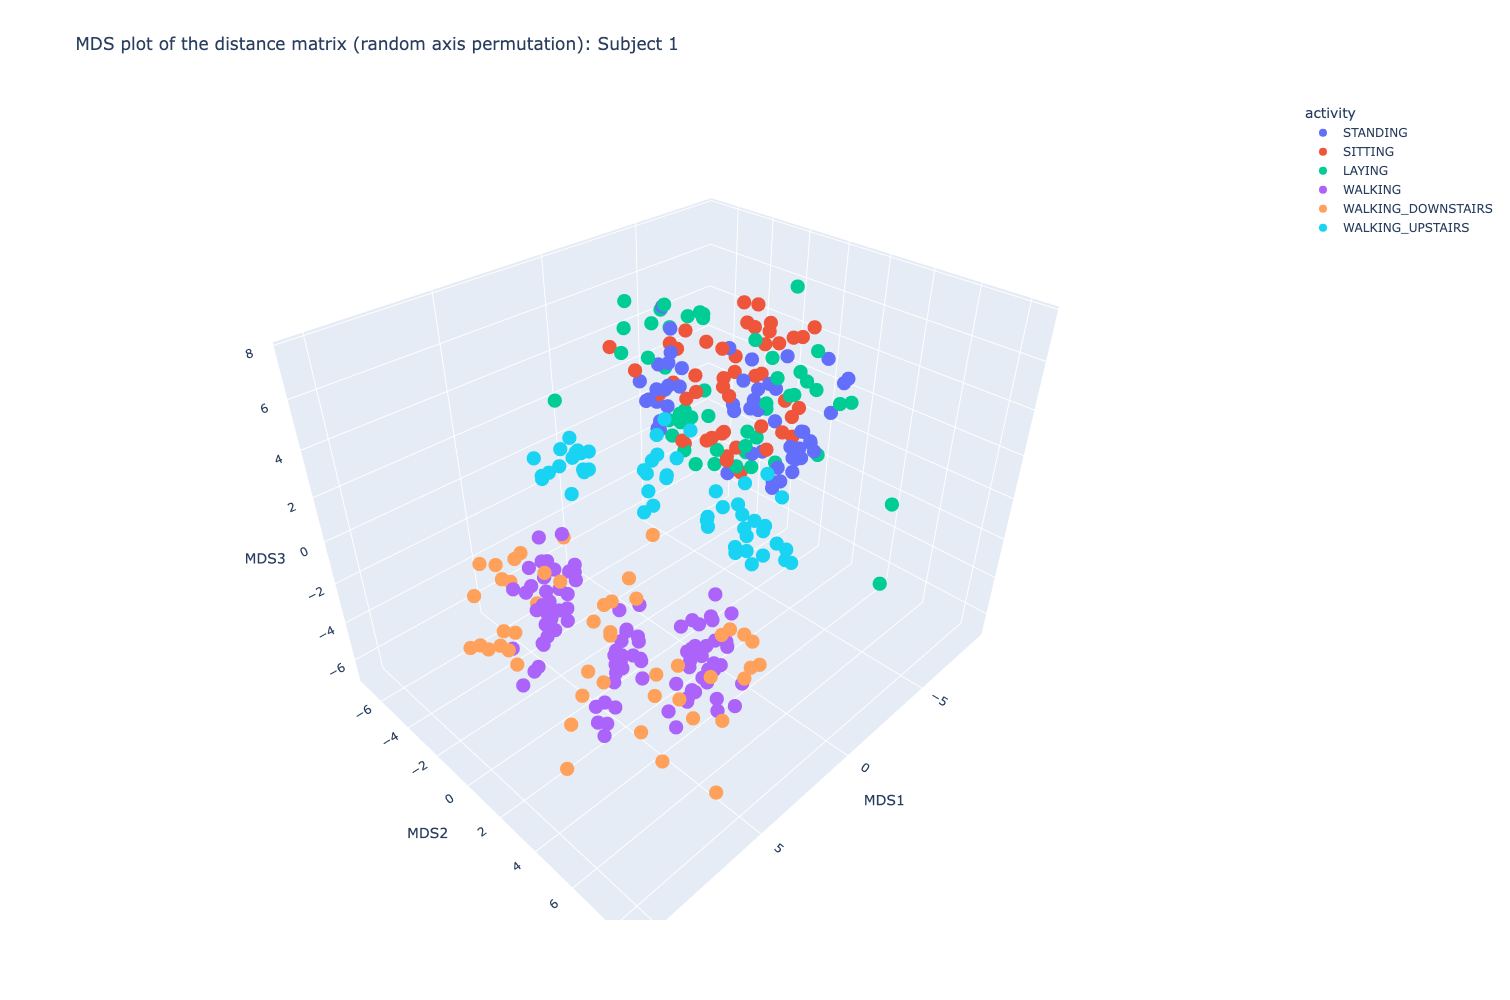

In [34]:
labels = shuffled_df['activity'].to_list()
mds = MDS(n_components = 3,dissimilarity='precomputed',random_state = 42)
mds_coords = mds.fit_transform(dm_shuffled)

mds_df_shuffled = pd.DataFrame(mds_coords,columns = ['MDS1','MDS2','MDS3'])
mds_df_shuffled['activity'] = labels

fig = px.scatter_3d(mds_df_shuffled, x = 'MDS1', y = 'MDS2',z = 'MDS3',color = 'activity',
                   title = f'MDS plot of the distance matrix (random axis permutation): Subject {subject_index}',
                   labels = {'color':'Activity'})

fig.update_layout(width = 1000,height = 1000)

fig.show()

# kNN Validation

We split the dataset (for the one subject) into train (70%) and testing sets (30%). For each sample in the testing set, we look at its $k$ nearest neighbors. The majority vote from these neighbors predict the class of our test sample. Accuracy score is given by
$$
\frac{\# \text{ Correct Predictions }}{\text{total} \# \text{ of samples}}
$$


It appears that our classifier does a perfect job with 100% accuracy.

Accuracy: 0.91


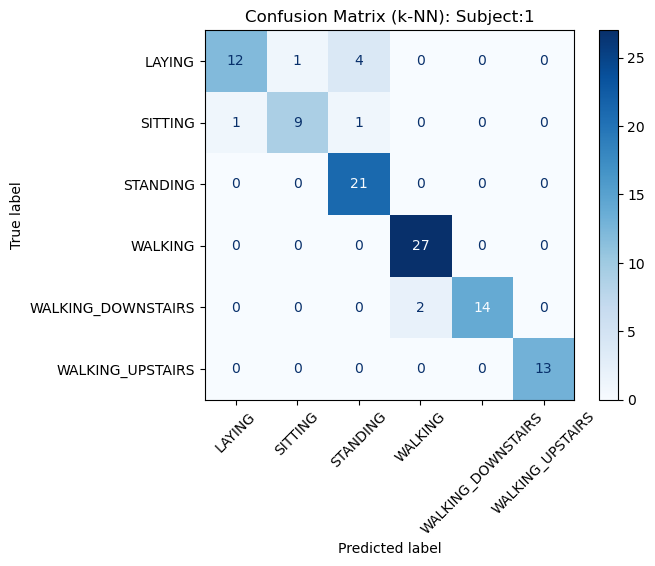

In [35]:
# Encode labels
le = LabelEncoder()
y = le.fit_transform(labels)
n_samples = len(y)

# Train/test split (get indices only, don't split data directly)
indices = np.arange(n_samples)
train_idx, test_idx, y_train, y_test = train_test_split(indices, y, test_size=0.3,random_state = 42)

# Extract the required submatrices for scikit-learn:
# D_train: distances between train samples
# D_test: distances from test samples to train samples
D_train = dm_shuffled[np.ix_(train_idx, train_idx)]
D_test = dm_shuffled[np.ix_(test_idx, train_idx)]

# Set up k-NN with precomputed distances
k = 3
knn = KNeighborsClassifier(n_neighbors=k, metric='precomputed')

# Fit using D_train (square, train-train distances)
knn.fit(D_train, y_train)

# Predict using D_test (rectangular, test-train distances)
y_pred = knn.predict(D_test)

# Evaluate
accuracy = np.mean(y_pred == y_test)
print(f"Accuracy: {accuracy:.2f}")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix with readable labels (optional but better)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)

plt.title(f"Confusion Matrix (k-NN): Subject:{subject_index}")
plt.show()



### Explanation for the results

It appears that random axis shuffling did drop classification scores but not as much as anticipated. why? >>> 

# $\ell_2$ distance approach with only one stat

* Extract columns with one particular stat feature name e.g. tBodyAcc-mean()
* Do the $\ell_2$ analysis there.
* Repeat with shuffling.
The idea is to see if random axis shuffling on a reduced number of features have a greater effect.

# Fully Shuffle

you just have the number, you don't know what's what.

run a few more experiments
and get ready
